# Forecasting beer sales 

github: https://github.com/kohlicekjan/forecasting-beer-sales-ml

### Source
- https://scikit-learn.org/stable/index.html
- https://www.mariofilho.com/how-to-predict-multiple-time-series-with-scikit-learn-with-sales-forecasting-example/
- https://alkaline-ml.com/pmdarima/quickstart.html
- https://facebook.github.io/prophet/

In [1]:
import pandas as pd
import numpy as np
import os
import datetime
import matplotlib.pyplot as plt


from sklearn import datasets, linear_model, ensemble, gaussian_process, isotonic, kernel_ridge, neighbors, neural_network, svm, tree
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, max_error, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, train_test_split
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.cross_decomposition import PLSRegression
from sklearn.compose import TransformedTargetRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, FunctionTransformer,  StandardScaler, LabelEncoder, LabelBinarizer


from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

In [17]:
DATASET_NAME = 'all-trade'

DATA_PATH = f'./data/{DATASET_NAME}_data.csv'

MODEL_PATH = f'./models/{DATASET_NAME}_model.joblib'

RESULT_CSV_PATH = f'./results/{DATASET_NAME}_result.csv'
RESULT_EXCEL_PATH = f'./results/{DATASET_NAME}_result.xlsx'

In [35]:

data_dtype = {'SkuShort':'str', 'ProductGroup':'str', 'PrimaryPack':'str', 'Country':'str', 'IsLockdown':'bool'}

#data = pd.read_csv(DATA_PATH, header=0, decimal=",", dtype=data_dtype)

data_off_trade = pd.read_csv(f'./data/off-trade_data.csv', header=0, decimal=",", dtype=data_dtype)
data_on_trade = pd.read_csv(f'./data/on-trade_data.csv', header=0, decimal=",", dtype=data_dtype)

data = pd.concat([data_off_trade, data_on_trade], ignore_index=True)
data = data.sort_values(by=['Year','Week']).reset_index().drop(columns=['index'])

data.head()

,SkuShort,ProductGroup,PrimaryPack,Country,Year,Week,NumberWorkdays,AvgTemp,AvgRain,AvgSun,IsLockdown,PdtHl,PrevWeekPdtHl1,BgtHl,SalesHl,PrevWeekSalesHl1,PrevWeekSalesHl2,PrevYearSalesHl1,PrevYearSalesHl2,OldPredSalesHl
0,01015,CLEAR BEER,RB,CZ,2016,1,5,-1.164286,0.935714,1.014286,False,NaN,NaN,1637.344974,1805.0000,NaN,NaN,NaN,NaN,705.4995
1,01016,CLEAR BEER,RB,CZ,2016,1,5,-1.164286,0.935714,1.014286,False,NaN,NaN,293.344724,159.1128,NaN,NaN,NaN,NaN,160.0957
2,01022,CLEAR BEER,RB,CZ,2016,1,5,-1.164286,0.935714,1.014286,False,NaN,NaN,59.144115,72.4900,NaN,NaN,NaN,NaN,74.4420
3,01026,CLEAR BEER,RB,CZ,2016,1,5,-1.164286,0.935714,1.014286,False,NaN,NaN,10.669629,23.8392,NaN,NaN,NaN,NaN,8.8567
4,01027,CLEAR BEER,RB,CZ,2016,1,5,-1.164286,0.935714,1.014286,False,NaN,NaN,2.109411,3.9600,NaN,NaN,NaN,NaN,4.9003


In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72372 entries, 0 to 72371
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   SkuShort          72372 non-null  object 
 1   ProductGroup      72372 non-null  object 
 2   PrimaryPack       72372 non-null  object 
 3   Country           72372 non-null  object 
 4   Year              72372 non-null  int64  
 5   Week              72372 non-null  int64  
 6   NumberWorkdays    72372 non-null  int64  
 7   AvgTemp           72372 non-null  float64
 8   AvgRain           72372 non-null  float64
 9   AvgSun            72372 non-null  float64
 10  IsLockdown        72372 non-null  bool   
 11  PdtHl             32062 non-null  float64
 12  PrevWeekPdtHl1    31998 non-null  float64
 13  BgtHl             58483 non-null  float64
 14  SalesHl           72372 non-null  float64
 15  PrevWeekSalesHl1  70488 non-null  float64
 16  PrevWeekSalesHl2  69849 non-null  float6

In [24]:
data.describe()

,Year,Week,NumberWorkdays,AvgTemp,AvgRain,AvgSun,PdtHl,PrevWeekPdtHl1,BgtHl,SalesHl,PrevWeekSalesHl1,PrevWeekSalesHl2,PrevYearSalesHl1,PrevYearSalesHl2,OldPredSalesHl
count,72372.000000,72372.000000,72372.000000,72372.000000,72372.000000,72372.000000,32062.000000,31998.000000,58483.000000,72372.000000,70488.000000,69849.000000,52171.000000,37630.000000,67560.000000
mean,2018.243395,25.899284,4.786478,10.280443,1.670258,4.887993,587.751535,704.908409,714.883316,628.270869,626.503793,626.645808,676.475289,646.837037,660.865138
std,1.536283,15.093055,0.494564,7.698657,1.652070,2.997295,1513.987828,1756.892297,1472.091049,1521.145699,1557.637045,1562.196555,1599.865826,1530.325451,1514.017151
min,2016.000000,1.000000,2.000000,-8.278571,0.000000,0.142857,0.052800,0.052800,-28.562282,0.000000,0.000000,0.000000,0.000000,0.000000,0.053200
25%,2017.000000,13.000000,5.000000,3.478571,0.464286,2.164286,25.161232,31.694398,53.586315,26.760000,30.000000,30.288000,40.800000,44.700000,37.978500
50%,2018.000000,25.000000,5.000000,9.964286,1.131250,4.707143,114.297907,135.957698,195.276000,122.300000,121.200000,121.720000,155.600000,159.535000,150.000350
75%,2020.000000,39.000000,5.000000,17.664286,2.364286,7.135165,450.729540,526.731884,661.965039,515.100000,498.765000,498.960000,572.190000,562.400000,577.106600
max,2021.000000,53.000000,5.000000,25.814286,7.957143,13.864286,25903.784615,25903.784615,16006.808529,24281.500000,24281.500000,24281.500000,24281.500000,21446.300000,24865.201400


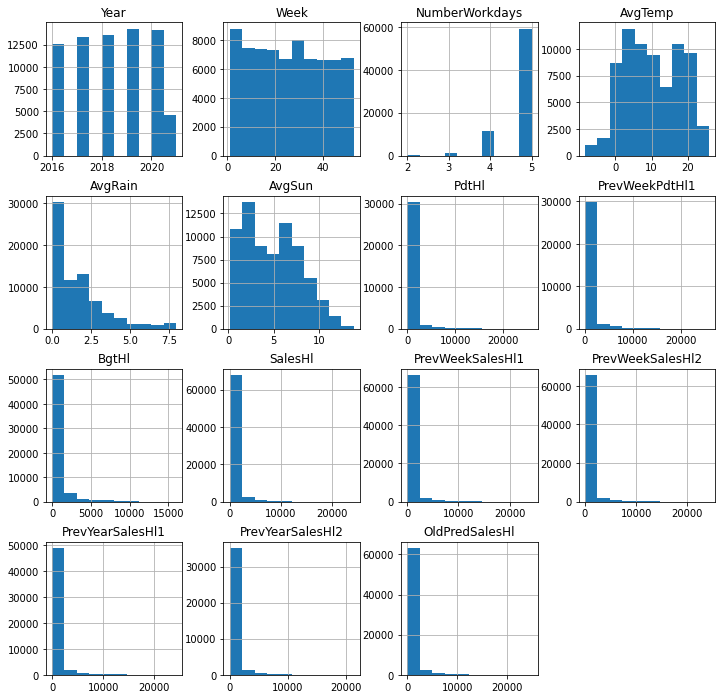

In [25]:
data.hist(figsize=[12,12])
plt.show()

<AxesSubplot:xlabel='Year,Week'>

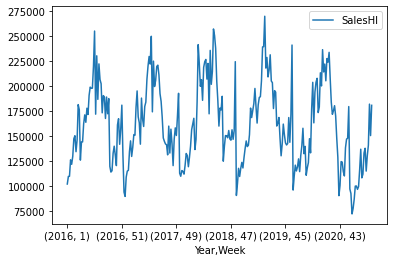

In [26]:
data.groupby(['Year','Week']).sum().plot(y=['SalesHl'])

## Create X, y

In [27]:
cols_drop = ['SalesHl', 'OldPredSalesHl', 'BgtHl'] #'SkuShort', 'ProductGroup', 'PrimaryPack', 'Country', 'Year'

X = data.drop(cols_drop, axis=1)
X_raw = data.drop(cols_drop, axis=1)
y = pd.DataFrame(data.SalesHl).round(0).astype(int)
y_oldPred = pd.DataFrame(data.OldPredSalesHl).fillna(0).round(0).astype(int)


## Imputer

In [ ]:
#X = X.fillna(0)
#X = X.dropna(inplace=True)

si = SimpleImputer(strategy='mean')
#si = SimpleImputer(strategy='constant', verbose=0)

si.fit(X)
X = si.transform(X)

## Add AVG column

In [ ]:
#Avg 
X['AvgPrevWeekSalesHl'] = X[['PrevWeekSalesHl1', 'PrevWeekSalesHl2']].mean(axis=1).round(0).astype('int64')
X['AvgPrevYearSalesHl'] = X[['PrevYearSalesHl1', 'PrevYearSalesHl2']].mean(axis=1).round(0).astype('int64')
X['AvgPrevAllSalesHl'] = X[['PrevYearSalesHl1', 'PrevYearSalesHl2', 'PrevWeekSalesHl1', 'PrevWeekSalesHl2']].mean(axis=1).round(0).astype('int64')

## LabelEncoder

In [31]:
#X['Date'] = X[['Year','Week']].apply(lambda x : datetime.datetime.strptime(f'{x[0]}-W{x[1]}-1', "%Y-W%W-%w"), axis=1)
#X.Date = X.Date.map(datetime.datetime.toordinal)

X.SkuShort = LabelEncoder().fit_transform(X.SkuShort)
X.ProductGroup = LabelEncoder().fit_transform(X.ProductGroup)
X.PrimaryPack = LabelEncoder().fit_transform(X.PrimaryPack)
X.Country = LabelEncoder().fit_transform(X.Country)

# #round weather
# X.AvgTemp = X.AvgTemp.round(0).astype('int64')
# X.AvgRain = X.AvgRain.round(0).astype('int64')
# X.AvgSun = X.AvgSun.round(0).astype('int64')



X.head()

,SkuShort,ProductGroup,PrimaryPack,Country,Year,Week,NumberWorkdays,AvgTemp,AvgRain,AvgSun,IsLockdown,PdtHl,PrevWeekPdtHl1,PrevWeekSalesHl1,PrevWeekSalesHl2,PrevYearSalesHl1,PrevYearSalesHl2,AvgPrevWeekSalesHl,AvgPrevYearSalesHl,AvgPrevAllSalesHl
0,6,1,6,0,2016,1,5,-1,1,1,False,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
1,7,1,6,0,2016,1,5,-1,1,1,False,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
2,8,1,6,0,2016,1,5,-1,1,1,False,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
3,10,1,6,0,2016,1,5,-1,1,1,False,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
4,11,1,6,0,2016,1,5,-1,1,1,False,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0


## Split train, test

In [32]:
train_index = len(X[(X.Year <= 2020) | ((X.Year == 2021) & (X.Week < 10))])
# train_index = len(X[(X.Year <= 2019) | ((X.Year == 2020) & (X.Week < 45))])

X_train = X.iloc[:train_index]
y_train = y.iloc[:train_index]

X_test = X.iloc[train_index:]
X_test_raw = X_raw.iloc[train_index:]
y_test = y.iloc[train_index:]
y_test_oldPred = y_oldPred.iloc[train_index:]

X_test.head()

,SkuShort,ProductGroup,PrimaryPack,Country,Year,Week,NumberWorkdays,AvgTemp,AvgRain,AvgSun,IsLockdown,PdtHl,PrevWeekPdtHl1,PrevWeekSalesHl1,PrevWeekSalesHl2,PrevYearSalesHl1,PrevYearSalesHl2,AvgPrevWeekSalesHl,AvgPrevYearSalesHl,AvgPrevAllSalesHl
69911,6,1,6,0,2021,10,5,2,1,3,True,7361.289056,5214.431913,8267.8000,4305.7000,9069.8000,7285.3000,6287,8178,7232
69912,7,1,6,0,2021,10,5,2,1,3,True,302.937182,331.508610,109.9296,230.6304,175.1112,157.1328,170,166,168
69913,11,1,6,0,2021,10,5,2,1,3,True,NaN,NaN,9.8208,10.4544,5.9400,17.4240,10,12,11
69914,13,1,6,0,2021,10,5,2,1,3,True,NaN,14.285714,519.0800,364.8400,168.5200,266.8400,442,218,330
69915,14,1,6,0,2021,10,5,2,1,3,True,252.000000,NaN,864.0000,NaN,NaN,NaN,432,0,216


## Scaler

In [33]:
scaler = MinMaxScaler() #0.5734, 0.8004
#scaler = MaxAbsScaler() #0.5690, 0.7966
#scaler = StandardScaler()

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Regressor

In [12]:
# param_grid = dict()
# #alpha=[1, 0.5, 0.1, 0.05, 0.001, 0.0005, 0.0001],fit_intercept=[True, False], verbose=[True, False], normalize=[True, False], precompute=[True, False], copy_X=[True, False], fit_path=[True, False], positive=[True, False], jitter=[True, False]
# clf = GridSearchCV(model, param_grid, n_jobs=2) #, random_state=0
# search = clf.fit(X_train, y_train.values.ravel())
# #print(search.cv_results_)
# print(search.best_score_)
# print(search.best_params_)

In [34]:
# Create linear regression object

#NOT model = ensemble.AdaBoostRegressor()
#tree.DecisionTreeRegressor(random_state=0)
#model = ensemble.BaggingRegressor(base_estimator=svm.SVR(), bootstrap=True, bootstrap_features=False, n_estimators=200, oob_score=False, warm_start=True) # ON-TRADE: ,OFF-TRADE: 0.79
#model = ensemble.ExtraTreesRegressor(n_jobs=3) # ON-TRADE: ,OFF-TRADE: 0.7962
#model = ensemble.GradientBoostingRegressor()
#model = ensemble.RandomForestRegressor(n_estimators=1000, n_jobs=3, bootstrap=True, criterion='mse', oob_score=True) # ON-TRADE: ,OFF-TRADE: 0.7933 
#NOT model = ensemble.StackingRegressor(estimators=[('lgbm', lgb.LGBMRegressor()),('hgb', ensemble.HistGradientBoostingRegressor())],final_estimator=ensemble.BaggingRegressor(), n_jobs=4, passthrough=False) 
#model = ensemble.VotingRegressor([('lgbm', lgb.LGBMRegressor(n_estimators=5000, learning_rate=0.005)), ('rf', ensemble.RandomForestRegressor(n_estimators=1000))]) # ON-TRADE: ,OFF-TRADE: 0.8143
#model = ensemble.HistGradientBoostingRegressor(random_state=1, loss='least_squares', learning_rate=0.05, max_iter=350, max_leaf_nodes=70, early_stopping=False) # ON-TRADE: ,OFF-TRADE: 0.7937 

#NOT model = gaussian_process.GaussianProcessRegressor()
#NOT model = isotonic.IsotonicRegression()

#NOT model = kernel_ridge.KernelRidge(alpha=1.0)# ON-TRADE: ,OFF-TRADE: 0.7827

# #option CV
#model = linear_model.LogisticRegression(max_iter=10)
#model = linear_model.LinearRegression(copy_X=False, fit_intercept=True, normalize=False, positive=False)# ON-TRADE: ,OFF-TRADE: 0.7875
#model = linear_model.Ridge(max_iter=1000, copy_X=False, fit_intercept=True, normalize=True, solver='sparse_cg')# ON-TRADE: ,OFF-TRADE: 0.7876
#model = linear_model.SGDRegressor(max_iter=1500, early_stopping=False, alpha=0.0001, average=True, epsilon=0.1,eta0=0.01, fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling', loss='huber', penalty='l2', power_t=0.1, shuffle=True, warm_start=True) # ON-TRADE: ,OFF-TRADE:  0.7819 

#model = linear_model.ElasticNet(max_iter=2000, alpha=0.001, copy_X=False, fit_intercept=True, l1_ratio=1, normalize=True, positive=False, precompute=False, selection='random', warm_start=True)# ON-TRADE: ,OFF-TRADE: 0.7875
#model = linear_model.Lars(n_nonzero_coefs=1000) # ON-TRADE: , OFF-TRADE: 0.7875 {'copy_X': True, 'fit_intercept': True, 'fit_path': True, 'jitter': False, 'normalize': False, 'precompute': False, 'verbose': True}
#model = linear_model.LassoLars(max_iter=500) # ON-TRADE: , OFF-TRADE: 0.7875 {'alpha': 0.001, 'copy_X': True, 'fit_intercept': True, 'fit_path': True, 'jitter': False, 'normalize': True, 'positive': False, 'precompute': True, 'verbose': True}
#model = linear_model.OrthogonalMatchingPursuit() # ON-TRADE: , OFF-TRADE: 0.7035 {'fit_intercept': True, 'normalize': True}
#model = linear_model.ARDRegression(n_iter=500, compute_score=True, copy_X=True, fit_intercept=True, normalize=False) # ON-TRADE: , OFF-TRADE: 0.7875
#model = linear_model.BayesianRidge(n_iter=500, compute_score=True, copy_X=True, fit_intercept=True, normalize=True) 

#model = linear_model.HuberRegressor(max_iter=500, epsilon=1.6, fit_intercept=True, warm_start=True) # ON-TRADE: , OFF-TRADE: 0.7805
#model = linear_model.RANSACRegressor(max_trials=500) #ON-TRADE: , OFF-TRADE: 0.7225
#model = linear_model.TheilSenRegressor(max_iter=500, n_jobs=-1) # ON-TRADE: , OFF-TRADE: 0.7582 {'copy_X': False, 'fit_intercept': True, 'verbose': True}

#NOT model = linear_model.PoissonRegressor(max_iter=500)
#model = linear_model.TweedieRegressor(max_iter=500, alpha=0.05, fit_intercept=False, link='auto', power=0, warm_start=True) # ON-TRADE: , OFF-TRADE: 0.7871
#NOT model = linear_model.GammaRegressor(max_iter=500) # ON-TRADE: ,OFF-TRADE:
#NOT model = linear_model.PassiveAggressiveRegressor(random_state=0, fit_intercept=True) # ON-TRADE: , OFF-TRADE: 0.6938

#model = neighbors.KNeighborsRegressor(n_neighbors=7, weights='uniform', leaf_size=30, n_jobs=-1) # ON-TRADE: , OFF-TRADE: 0.7941
#NOT model = neighbors.RadiusNeighborsRegressor(radius=5.0, weights='distance')

#NOT model = svm.LinearSVR() # ON-TRADE: , OFF-TRADE: 0.7049


hgbModel = ensemble.HistGradientBoostingRegressor(random_state=0, loss='least_squares', learning_rate=0.05, max_iter=350, max_leaf_nodes=70, early_stopping=False)
mlpModel = neural_network.MLPRegressor(activation='relu', solver='adam', learning_rate='constant', nesterovs_momentum=True, shuffle=False, verbose=False, warm_start=True, random_state=1, hidden_layer_sizes=60, max_iter=1000, early_stopping=False)
rfModel = ensemble.RandomForestRegressor(random_state=0,n_estimators=1000, bootstrap=True, criterion='mse', oob_score=True, n_jobs=3)
# knModel = neighbors.KNeighborsRegressor(n_neighbors=7, weights='uniform', leaf_size=30, n_jobs=-1)
# sgdModel = linear_model.SGDRegressor(max_iter=1500, early_stopping=False, alpha=0.0001, average=True, epsilon=0.1,eta0=0.01, fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling', loss='huber', penalty='l2', power_t=0.1, shuffle=True, warm_start=True)

xgbModel = XGBRegressor(random_state=0, tree_method='approx', booster='dart', n_jobs=3)
# lgbmModel = LGBMRegressor(n_estimators=10000, learning_rate=0.001, num_leaves=300, n_jobs=3)

estimators = [('hgb', hgbModel), ('mlp', mlpModel), ('rf', rfModel), ('xgb', xgbModel)]

model = ensemble.VotingRegressor(estimators, weights=[1, 0.5, 0.5, 0.8], n_jobs=3)


# Train the model using the training sets
model.fit(X_train, y_train.values.ravel())

# Make predictions using the testing set
y_pred = model.predict(X_test)
y_pred[y_pred < 0] = 0

# # The mean squared error
# print('Mean squared error: %.4f'% mean_squared_error(y_test, y_pred))

print(DATASET_NAME)
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.4f'% r2_score(y_test, y_pred))

# #Best possible score is 1.0, lower values are worse.
# print('Explained variance regression: %.4f'% explained_variance_score(y_test, y_pred))

#max_error metric calculates the maximum residual error.
print('Maximum residual error: %.4f'% max_error(y_test, y_pred))

# #Mean absolute percentage error regression loss.
# print('Mean absolute percentage error regression loss: %.4f'% mean_absolute_percentage_error(y_test, y_pred))

print('Old Coefficient of determination: %.4f'% r2_score(y_test, y_test_oldPred))
print('Old Maximum residual error: %.4f'% max_error(y_test, y_test_oldPred))

# print(f'The number of iterations as selected by early stopping: {model.n_iter_}')
# print(f'The scores at each iteration on the training data: {model.train_score_}')
# print(f'The scores at each iteration on the held-out validation data: {model.validation_score_}')
# print(f'Boolean mask for the categorical features: {model.is_categorical_}')

#on-trade
#LGBMRegressor = 0.2801, 0.7314
#MLPRegressor = 0.1532, 0.2210
#VotingRegressor = 0.5829 (0.6246), 0.8377 (0.8027)
#HistGradientBoostingRegressor = 0.4634, 0.8241
#RandomForestRegressor = 0.4809, 0.7280

#off-trade
#LGBMRegressor = , 0.8537
#MLPRegressor = 0.7418, 0.7768
#VotingRegressor = 0.8686 (0.8584), 0.8561 (0.8597)
#HistGradientBoostingRegressor = 0.8640, 0.8470
#RandomForestRegressor = 0.8557, 0.8418


#all-trade
#VotingRegressor = 0. (0.), 0. (0.)

MemoryError: 

## Model analysis

In [98]:
def get_percentage_diff(previous, current):
    return 1 - (abs(previous - current)/max(previous, current))

result = test.copy(deep=False)
result["PredictSalesHl"] = y_pred

resultWeek = result.groupby(['Year','Week']).sum()
resultWeek = resultWeek[['SalesHl', 'OldPredSalesHl', 'PredictSalesHl']].apply(lambda x : pd.Series({'OldPredSalesHl': get_percentage_diff(x[0], x[1]), 'NewPredSalesHl': get_percentage_diff(x[0], x[2])}) , axis=1)
resultWeek['NewPredSalesHlDiff'] = resultWeek.NewPredSalesHl-resultWeek.OldPredSalesHl
resultWeek = (100. * resultWeek).round(1).astype(str) + '%'
print(resultWeek)

resultYear = result.groupby(['Year']).sum()
resultYear= resultYear[['SalesHl', 'OldPredSalesHl', 'PredictSalesHl']].apply(lambda x : pd.Series({'OldPredSalesHl': get_percentage_diff(x[0], x[1]), 'NewPredSalesHl': get_percentage_diff(x[0], x[2])}) , axis=1)
resultYear['NewPredSalesHlDiff'] = resultYear.NewPredSalesHl-resultYear.OldPredSalesHl
resultYear = (100. * resultYear).round(1).astype(str) + '%'
print(resultYear)

# resultSkuShort = result.groupby(['SkuShort']).sum()
# resultSkuShort = resultSkuShort[['SalesHl', 'OldPredSalesHl', 'PredictSalesHl']].apply(lambda x : pd.Series({'OldPredSalesHl': get_percentage_diff(x[0], x[1]), 'NewPredSalesHl': get_percentage_diff(x[0], x[2])}) , axis=1)
# resultSkuShort['NewPredSalesHlDiff'] = resultSkuShort.NewPredSalesHl-resultSkuShort.OldPredSalesHl
# resultSkuShort = (100. * resultSkuShort).round(1).astype(str) + '%'

# print(resultSkuShort)

          OldPredSalesHl NewPredSalesHl NewPredSalesHlDiff
Year Week                                                 
2021 10            97.8%          95.3%              -2.5%
     11            93.7%          95.8%               2.1%
     12            95.3%          95.7%               0.3%
     13            91.6%          97.6%               6.0%
     14            90.5%          84.9%              -5.6%
     15            98.1%          93.0%              -5.1%
     16            92.6%          95.7%               3.1%
     17            98.9%          91.0%              -7.8%
     18            91.4%          78.8%             -12.6%
     19            92.9%          88.3%              -4.6%
     OldPredSalesHl NewPredSalesHl NewPredSalesHlDiff
Year                                                 
2021          94.6%          94.7%               0.1%


In [99]:
# from sklearn.inspection import permutation_importance

# result = permutation_importance(
#     model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)

#X_feature_names = X.columns.tolist()
# forest_importances = pd.Series(result.importances_mean, index=X_feature_names)

# fig, ax = plt.subplots()
# forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
# ax.set_title("Feature importances using permutation on full model")
# ax.set_ylabel("Mean accuracy decrease")
# fig.tight_layout()
# plt.show()

In [100]:
# from skater.core.explanations import Interpretation
# from skater.model import InMemoryModel


# examples_numpy = pd.concat([pd.DataFrame(X_train).sample(n=50), pd.DataFrame(X_test).sample(n=50)]).to_numpy()

# # wrap our base model with InMemoryModel instance
# annotated_model = InMemoryModel(
#     model.predict, 
#     examples = examples_numpy, 
#     model_type = 'regressor'
# )

# interpreter = Interpretation(examples_numpy, feature_names=feature_names)

In [101]:
#interpreter.feature_importance.plot_feature_importance(annotated_model, progressbar=False)

In [102]:
# interpreter.partial_dependence.plot_partial_dependence(
#     feature_names, annotated_model, grid_resolution=20, progressbar=False
# )

In [103]:
# from skater.core.local_interpretation.lime.lime_tabular import LimeTabularExplainer

# # create an explainer
# explainer = LimeTabularExplainer(examples_numpy, feature_names=feature_names, mode="regression")

# # explain something
# explanation = explainer.explain_instance(examples_numpy[5], annotated_model)

# # show the explanation
# explanation.show_in_notebook()

In [104]:
# import shap
# #shap.initjs()

# X100 = shap.utils.sample(train, 100)

# explainer = shap.Explainer(model)
# shap_values = explainer(X100)

# shap.plots.waterfall(shap_values[0])

In [105]:
# shap.plots.force(shap_values[0])

In [106]:
# shap.plots.force(shap_values)

In [107]:
# shap.plots.scatter(shap_values, color=shap_values)

In [108]:
# shap.plots.bar(shap_values)

In [109]:
# shap.plots.beeswarm(shap_values)

## Save Result

In [110]:
result = X_test_raw.copy(deep=False)
result["SalesHl"] = y_test
result["OldPredictSalesHl"] = y_test_oldPred
result["PredictSalesHl"] = y_pred

dir_path = os.path.dirname(RESULT_CSV_PATH)
if (not os.path.isdir(dir_path)):
    os.mkdir(dir_path)
 
result.to_csv(RESULT_CSV_PATH, index=False)
result.to_excel(RESULT_EXCEL_PATH, index=False)

## Save model

In [111]:
import joblib

dir_path = os.path.dirname(MODEL_PATH)
if (not os.path.isdir(dir_path)):
    os.mkdir(dir_path)

joblib.dump(model, MODEL_PATH, compress=True)

['./models/off-trade_model.joblib']

## Use model

In [112]:
# import joblib
# import os
# import numpy as np

# file = open(MODEL_PATH, 'rb')

# model = joblib.load(file)

# SkuShort = 2605
# Week = 23
# NumberWorkdays = 5
# AvgTemp = 15.892857142857142
# AvgRain = 3.5000000000000004
# AvgSun = 6.735714285714286
# IsLockdown = 0
# PdtHl = -1.0
# PrevWeekPdtHl1 = -1.0
# BgtHl = 6665
# PrevWeekBgtHl1 = 6665.949490847161
# PrevWeekSalesHl1 = 5020
# PrevWeekSalesHl2 = 5038
# SalesHl = 5386.5

# x = np.array([[SkuShort, Week,NumberWorkdays, AvgTemp, AvgRain, AvgSun, IsLockdown, PdtHl, PrevWeekPdtHl1, BgtHl, PrevWeekBgtHl1, PrevWeekSalesHl1, PrevWeekSalesHl2]])

# y_pred = model.predict(x)
# result = y_pred[0]

# def get_percentage_diff(previous, current):
#     return 1 - (abs(previous - current)/max(previous, current))

# print('Forecast sales: %.4f hl'% result)
# print('Coefficient of determination: %.4f'% get_percentage_diff(SalesHl, result))

#full with sku = 0.7678
#full = 0.7363